# Modeling elections

In [ ]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import pystan

## Data

The `electoral_votes` variable is a dictionary containing the number of Electoral College votes for each state. For example
```
  >>> electoral_votes['Indiana']
  11
```
Data from [Wikipedia: United_States_Electoral_College](https://en.wikipedia.org/wiki/United_States_Electoral_College)

The `survey_results` variable is a dictionary mapping from states to an array of survey results for each candidate. Each row in a survey results array represents one survey and each column represents one candidate. There are 3 columns, representing Trump (Republican), Biden (Democrat), and Other in that order. In the example below, Trump got 340 votes in the first survey, Biden got 258, and Other got 40.
```
  >>> survey_results['Indiana']
  array([[340, 258,  40],
         [240, 155,  10],
         [235, 155,  70],
         [308, 266,  84],
         [222, 161, 110]])
```
Data from [Wikipedia: Statewide opinion polling for the 2020 United States presidential election](https://en.wikipedia.org/wiki/Statewide_opinion_polling_for_the_2020_United_States_presidential_election)


In [ ]:
electoral_votes = {
    'Alabama': 9,
    'Alaska': 3,
    'Arizona': 11,
    'Arkansas': 6,
    'Colorado': 9,
}

survey_results = {
    'Alabama': np.array([[611, 397, 0, 0], [799, 528, 0, 0], [793, 403, 0, 0], [288, 264, 0, 0], [353, 219, 0, 0], [997, 554, 0, 0], [312, 232, 0, 0], [409, 227, 0, 0], [319, 234, 0, 0]]),
    'Alaska': np.array([[348, 320, 0, 0], [298, 253, 0, 0], [283, 277, 0, 0], [269, 198, 0, 0], [227, 177, 0, 0], [442, 389, 0, 0], [519, 486, 0, 0], [325, 318, 0, 0], [84, 74, 0, 0]]),
    'Arizona': np.array([[522, 478, 22, 0], [313, 356, 7, 7], [291, 304, 0, 0], [270, 288, 0, 0], [236, 264, 16, 0], [180, 184, 0, 0], [133, 151, 0, 0], [269, 321, 20, 0], [230, 250, 5, 0], [3337, 3621, 0, 0], [360, 392, 0, 0], [235, 235, 0, 0], [364, 396, 8, 0], [383, 409, 9, 9], [221, 216, 0, 0], [113, 128, 0, 0], [284, 278, 0, 0], [168, 212, 0, 0], [258, 270, 0, 0], [260, 266, 0, 0], [359, 402, 9, 0], [185, 202, 17, 0], [261, 320, 26, 0], [519, 584, 0, 0], [328, 342, 0, 0], [487, 520, 0, 0], [252, 312, 0, 0], [752, 768, 0, 0], [414, 441, 0, 0], [212, 230, 0, 0], [357, 398, 0, 8], [309, 378, 23, 0], [3357, 3034, 0, 0], [396, 490, 0, 0], [162, 169, 0, 0], [325, 402, 9, 9], [445, 426, 0, 0], [311, 350, 0, 0], [188, 193, 0, 0], [466, 456, 30, 0], [271, 295, 0, 0], [204, 192, 0, 0], [522, 547, 24, 12], [2547, 2348, 0, 0], [164, 172, 0, 0], [381, 445, 0, 0], [393, 428, 0, 0], [326, 395, 17, 9], [372, 413, 0, 0], [432, 470, 0, 0], [315, 343, 0, 0], [155, 176, 0, 0], [500, 500, 0, 0], [264, 294, 0, 0], [1230, 1088, 0, 0], [270, 282, 0, 0], [137, 159, 0, 0], [258, 237, 0, 0], [337, 372, 17, 9], [266, 312, 0, 0], [616, 670, 0, 0], [88, 90, 0, 0], [421, 461, 0, 0], [148, 145, 0, 0], [368, 353, 0, 0], [180, 188, 0, 0], [388, 426, 0, 0], [258, 300, 0, 0], [230, 235, 0, 0], [258, 312, 0, 0]]),
    'Arkansas': np.array([[478, 293, 0, 0], [462, 220, 0, 0], [493, 239, 0, 0], [209, 135, 0, 0], [408, 391, 0, 0]]),
    'Colorado': np.array([[408, 510, 0, 0], [1114, 1549, 0, 0], [283, 322, 0, 0], [320, 400, 0, 0], [312, 400, 32, 8], [978, 1359, 0, 0], [262, 325, 0, 0], [252, 306, 0, 0], [246, 307, 0, 0], [246, 306, 0, 0], [240, 312, 0, 0], [935, 1355, 0, 0], [240, 320, 0, 0], [246, 306, 0, 0], [365, 481, 0, 0], [328, 470, 0, 0], [457, 620, 0, 0], [240, 286, 0, 0], [280, 371, 0, 0], [216, 330, 0, 0], [133, 201, 0, 0]]),
}

for key, value in survey_results.items():
    survey_results[key] = np.concatenate((value[:,:2], value[:,2:3] + value[:,3:4]), axis=1)

states = sorted(survey_results.keys())
print('Modeling', len(states), 'states with', sum(electoral_votes[s] for s in states), 'electoral college votes')

Modeling 5 states with 38 electoral college votes


## Generative model

1. For each state we generate an $\vec{\alpha}$ vector, which defines a Dirichlet distribution over the proportion of votes that go to each of the 3 candidates whenever we do a survey – including the final survey, namely the election itself which we want to predict. The prior over each component of $\vec{\alpha}$ is taken as a Cauchy distribution with location 0 and scale 1. Since the components of $\vec{\alpha}$ are positive, we actually use the positive half-Cauchy distribution.

2. For each survey in a state we generate a probability vector $\vec{p_i} \sim \text{Dirichlet}(\vec{\alpha})$ for the probability that a voter selects each of the 3 candidates.

3. For each survey, we then generate the number of votes going to each candidate as $\vec{k_i} \sim \text{Multinomial}(\vec{p_i})$.

### Tasks

* Use Stan to sample from the posterior distribution over $\alpha$ and visualize your results. There are 5 states, so you will have 5 posteriors.
* The posteriors over $\alpha$ show a lot of variation between different states. Explain the results you get in terms of the model and the data.

In [ ]:
stan_code = '''
data {
    int S;  // Number of surveys
    int C;  // Number of candidates
    int survey_results[S, C];  // Number of votes for each candidate in each survey
    real cauchy_location;  // Prior hyperparameters for half-Cauchy over alpha
    real cauchy_scale;
}

parameters {
    vector<lower=0>[C] alpha;
    simplex[C] p[S];  // One probability vector for each survey
}

model {
    alpha ~ cauchy(cauchy_location, cauchy_scale);
    for (i in 1:S) {
        p[i] ~ dirichlet(alpha);
        survey_results[i] ~ multinomial(p[i]);
    }
}
'''
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a89b9d288c9c4fecf50d2e6275e90c2e NOW.


Posterior α samples and 95% confidence intervals for each state



Alabama
[[1.28827294e+01 8.40252544e+00 4.43300486e-02]
 [2.04461493e+02 1.28767969e+02 2.85185717e-01]]


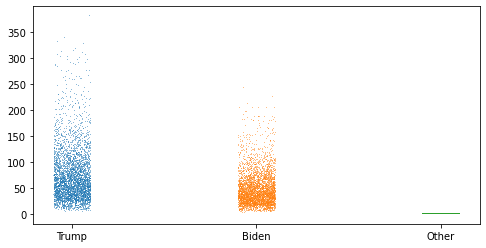

Alaska
[[3.89825468e+01 3.43419899e+01 5.76527679e-02]
 [9.57612811e+02 8.45112414e+02 6.88007604e-01]]


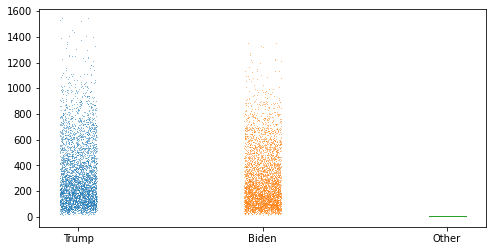

Arizona
[[29.57794467 31.51072309  0.11982687]
 [59.35710526 63.57188721  0.28745342]]


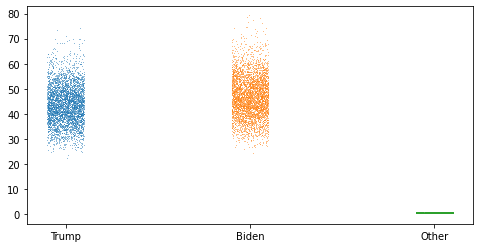

Arkansas
[[1.60791136e+00 1.07890106e+00 2.96440636e-02]
 [5.57039318e+01 3.41405982e+01 2.81931055e-01]]


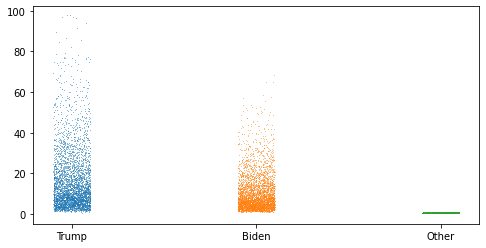

Colorado
[[3.18204862e+01 4.22985981e+01 6.96092015e-02]
 [1.27993262e+02 1.68778325e+02 2.40945144e-01]]


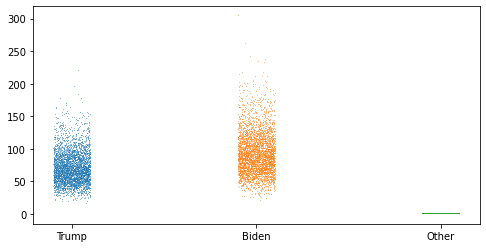

In [ ]:
# Sample results for all states

print('Posterior α samples and 95% confidence intervals for each state\n')

results = {}
for state in states:
    data = {
        'S': survey_results[state].shape[0],
        'C': 3,
        'survey_results': survey_results[state],
        'cauchy_location': 0,
        'cauchy_scale': 1}
    results[state] = stan_model.sampling(data=data)
    samples = results[state].extract()

    print(state)
    print(np.percentile(samples['alpha'], [2.5, 97.5], axis=0))
    plt.figure(figsize=(8,4))
    for i in range(3):
        plt.plot(sts.uniform.rvs(loc=i-0.1, scale=0.2, size=4000), samples['alpha'][:,i], ',', alpha=0.5)
    plt.xticks([0, 1, 2], ['Trump', 'Biden', 'Other'])
    plt.show()

## Simulation time

Use the posterior samples to predict the outcome of the presidential elections.

* Predict the probability that each candidate will win each state.
   * Use the posterior $\alpha$ samples to generate posterior predictive samples for $p$ – the proportion of votes each candidate would get in each state in an election.
   * Use these $p$ samples to estimate the probability that each candidate will win each state.
* Predict the probability that each candidate will win the presidential election.
   * Use the posterior predictive probability that each candidate will win each state to generate samples over the total number Electoral College votes each candidate would get in an election.
   * Use the total number of votes to generate samples over who would win the election.

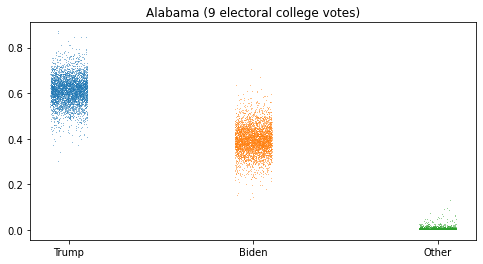

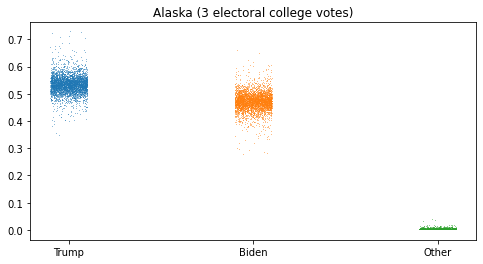

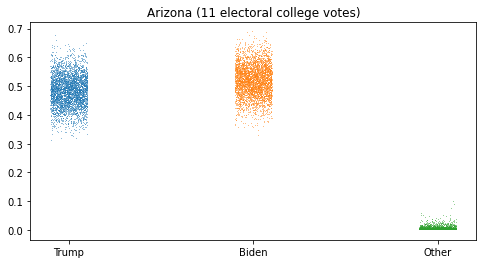

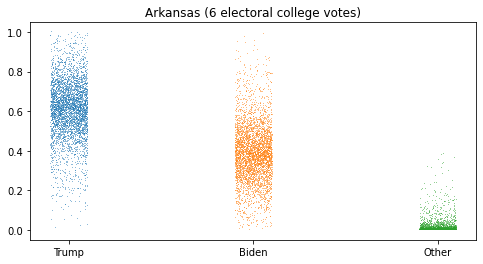

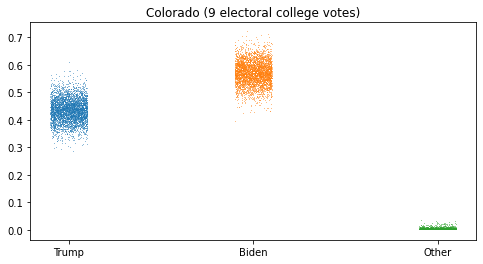

In [ ]:
# Generating predictive samples using SciPy

for state in states:

    # Use the posterior alpha samples to generate posterior predictive samples for p.
    # Each p represents the fraction of votes each candidate would get in each state
    # during an election.
    samples = results[state].extract()
    alpha = samples['alpha']
    p_predicted = np.empty(alpha.shape)
    for i in range(alpha.shape[0]):
        p_predicted[i] = sts.dirichlet.rvs(alpha[i])

    # Plot the results
    plt.figure(figsize=(8,4))
    for i in range(3):
        plt.plot(sts.uniform.rvs(loc=i-0.1, scale=0.2, size=4000), p_predicted[:,i], ',', alpha=0.5)
    plt.title(state + ' (' + str(electoral_votes[state]) + ' electoral college votes)')
    plt.xticks([0, 1, 2], ['Trump', 'Biden', 'Other'])

plt.show()

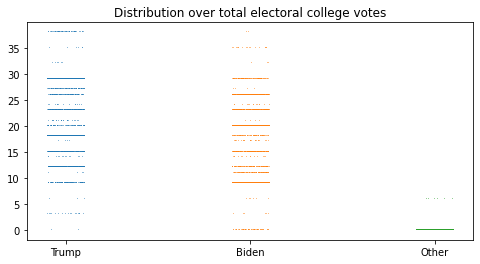

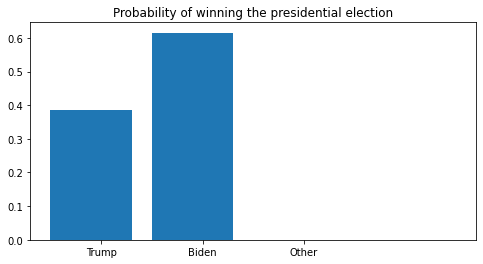

In [ ]:
# Generating winner simulation using SciPy
samples = {state: results[state].extract() for state in states}

# Use the posterior predictive probability that each candidate will win each state
# to generate samples over the total number Electoral College votes each candidate
# would get in an election.
total_votes = np.zeros((4000, 3))
overall_winner = np.zeros(4000)
for s in range(4000):
    for state in states:
        alpha = samples[state]['alpha'][s]
        p_predicted = sts.dirichlet.rvs(alpha)
        winner = p_predicted.argmax()
        total_votes[s, winner] += electoral_votes[state]
    overall_winner[s] = total_votes[s].argmax()

# Plot national results
plt.figure(figsize=(8,4))
for i in range(3):
    plt.plot(sts.uniform.rvs(loc=i-0.1, scale=0.2, size=4000), total_votes[:,i], ',', alpha=0.5)
plt.xticks([0, 1, 2], ['Trump', 'Biden', 'Other'])
plt.title('Distribution over total electoral college votes')

plt.figure(figsize=(8,4))
plt.hist(overall_winner, bins=[-0.5, 0.5, 1.5, 2.5, 3.5], width=0.8, align='mid', density=True)
plt.xticks([0, 1, 2], ['Trump', 'Biden', 'Other'])
plt.title('Probability of winning the presidential election')
plt.show()